In [2]:
import gc
import random

from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc

import h5py
from concurrent.futures import ThreadPoolExecutor

import cv2
import numpy as np
import pandas as pd
import pydicom as dicom
from keras import Model, Input
from keras.src.layers import Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.callbacks import Callback
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.python.framework import constant_op
from tensorflow.python.ops import clip_ops, math_ops
from tensorflow.keras import backend as K
from keras.src import ops
from tqdm import tqdm

2024-07-21 01:50:03.585346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-21 01:50:04.221611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### ファイルの定義

In [3]:
train_image_hdf5 = "train-image.hdf5"
train_metadata_csv = "train-metadata.csv"
test_image_hdf5 = "test-image.hdf5"
test_metadata_csv = "test-metadata.csv"
sample_submission_csv = "sample_submission.csv"

base_path = "/home/toru/PycharmProjects/isic-2024-challenge"

In [4]:
CONFIG = {
    "SEED": 42,
    "N_FOLDS": 5,
    "N_EPOCHS": 100,
    "BATCH_SIZE": 32,
    "VAL_BATCH_SIZE": 50,
    "LR": 0.001,
    "IMAGE_HEIGHT": 224,
    "IMAGE_WIDTH": 224,
    "IMAGE_CHANNEL": 3,
    "N_CLASSES": 1,
    "PATIENCE": 3,
    "TRAIN_RATIO": 0.8,
    "VAL_RATIO": 0.1,
    "TEST_RATIO": 0.1,
}

In [5]:
df_train = pd.read_csv(f"{base_path}/{train_metadata_csv}")
df_test = pd.read_csv(f"{base_path}/{test_metadata_csv}")

/tmp/ipykernel_112825/1314295926.py:1: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv(f"{base_path}/{train_metadata_csv}")


In [6]:
train_isic_ids = df_train["isic_id"].values

train_isic_ids_positive = df_train[df_train["target"] == 1]["isic_id"].values
train_isic_ids_negative = df_train[df_train["target"] == 0]["isic_id"].values

In [13]:
def get_image_and_label(hdf, isic_id):
    # 画像を取得
    image_data = hdf[isic_id][()]

    # Convert the binary data to a numpy array
    image_data = np.frombuffer(image_data, np.uint8)

    # Decode the image from the numpy array
    image_data = cv2.cvtColor(cv2.imdecode(image_data, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    image_data = cv2.resize(image_data, (CONFIG["IMAGE_HEIGHT"], CONFIG["IMAGE_WIDTH"]))

    # 画像の正規化 (0 ~ 1) に変換
    image_data = (image_data - image_data.min()) / (image_data.max() - image_data.min())
    
    # uint8 に変換
    image_data = (image_data * 255).astype(np.uint8)
    
    # クラスを取得する. これが学習時のラベルになる
    label = df_train[df_train["isic_id"] == isic_id]["target"].values[0]
    return image_data, label


def augmentation(image):
    # 画像をぼかす
    image = cv2.GaussianBlur(image, (5, 5), 0)

    # 明るさを変える
    image = tf.image.random_brightness(image, 0.1).numpy()

    # ホワイトノイズを加える
    image = image + np.random.normal(0, 0.1, image.shape)

    # 画像を確率で反転
    if np.random.rand() > 0.5:
        image = tf.image.random_flip_left_right(image).numpy()

    # 特定の範囲を切り抜く
    n_cut = np.random.randint(1, 5)
    for _ in range(n_cut):
        WINDOW_SIZE = np.random.randint(10, 50)
        x_min = np.random.randint(0, image.shape[0] - WINDOW_SIZE)
        x_max = x_min + WINDOW_SIZE
        y_min = np.random.randint(0, image.shape[1] - WINDOW_SIZE)
        y_max = y_min + WINDOW_SIZE
        image[x_min:x_max, y_min:y_max] = 0

    # 画像を回転
    angle = np.random.randint(0, 360)
    image = tf.image.rot90(image, k=angle // 90).numpy()

    return image


def generator(isic_ids,
              batch_size=CONFIG["BATCH_SIZE"],
              mode="train",
              is_augmentation=False,
              is_shuffle=False,
              is_one_epoch=False):
    hdf = None
    if mode == "train":
        hdf = h5py.File(f"{base_path}/{train_image_hdf5}", "r")
    elif mode == "test":
        hdf = h5py.File(f"{base_path}/{test_image_hdf5}", "r")
    else:
        raise ValueError("mode must be 'train' or 'test'")

    while True:
        if is_shuffle:
            random.shuffle(isic_ids)

        for i in range(0, len(isic_ids), batch_size):
            end = min(i + batch_size, len(isic_ids))
            batch_isic_ids = isic_ids[i:end]
            images = []
            labels = []
            for isic_id in batch_isic_ids:
                image, label = get_image_and_label(hdf, isic_id)

                if is_augmentation:
                    image = augmentation(image)

                images.append(image)
                labels.append(label)

            # numpy 配列に変換
            images = np.array(images).astype(np.uint8)
            labels = np.array(labels).astype(np.uint8)

            yield images, labels

        if is_one_epoch:
            break

image shape: (4, 224, 224, 3)
image type: uint8
image max: 255, min: 0
label shape: (4,)


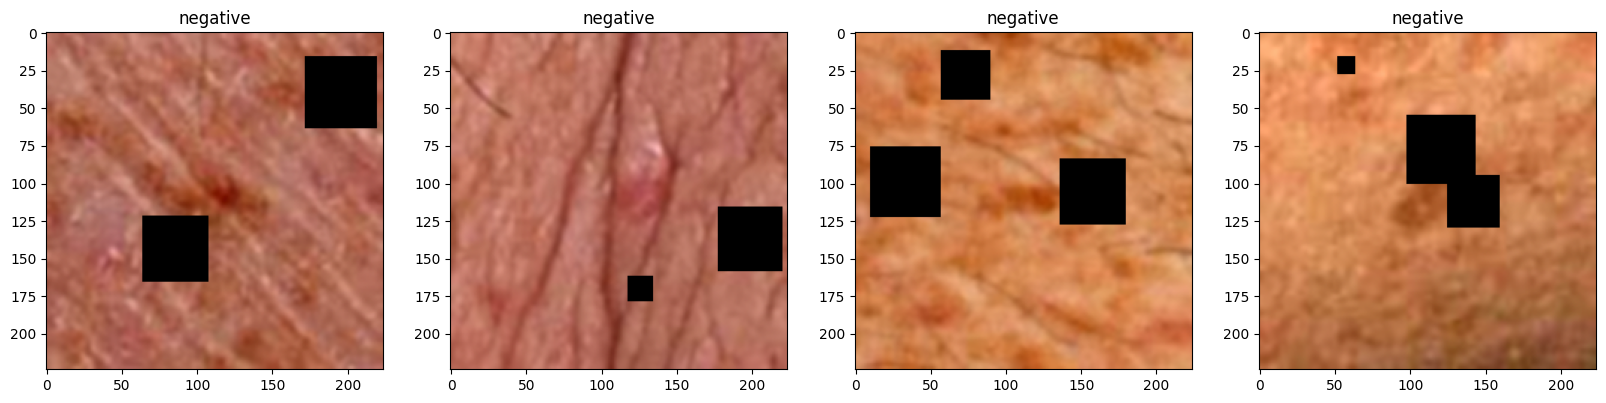

In [14]:
show_img_size = 4
# 画像を取得して表示
plt.figure(figsize=(20, 5))
for images, labels in generator(train_isic_ids, batch_size=show_img_size, mode="train", is_shuffle=False,
                                is_one_epoch=True, is_augmentation=True):
    # 画像の情報を表示
    print(f"image shape: {images.shape}")
    print(f'image type: {images.dtype}')
    print(f"image max: {images.max()}, min: {images.min()}")
    print(f"label shape: {labels.shape}")

    for i, (image, label) in enumerate(zip(images, labels)):
        # 最小値を0, 最大値を1にする
        
        plot_size = min(show_img_size, len(images))
        plt.subplot(1, plot_size, i + 1)
        plt.imshow(image)
        if label == 1:
            plt.title(f"positive")
        else:
            plt.title("negative")
    plt.show()

    break

In [ ]:
# すべての画像とラベルを読み込む
images = []
labels = []

hdf = h5py.File(f"{base_path}/{train_image_hdf5}", "r")
for isic_id in tqdm(train_isic_ids):
    image, label = get_image_and_label(hdf, isic_id)
    images.append(image)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

# npy ファイルに保存
np.save("images.npy", images)
np.save("labels.npy", labels)

 12%|█▏        | 47866/401059 [16:44<2:04:29, 47.28it/s]